In [1]:
!pip -q install tensorflow_similarity

     |████████████████████████████████| 191 kB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 4.2 MB 40.3 MB/s 
     |████████████████████████████████| 13.5 MB 48.6 MB/s 
     |████████████████████████████████| 188 kB 65.0 MB/s 
     |████████████████████████████████| 1.1 MB 54.7 MB/s 


In [2]:
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_similarity as tfsim


tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity: 0.15.8


In [3]:
# This determines the number of classes used during training.
# Here we are using all the classes.
num_known_classes = 10
class_list = random.sample(population=range(10), k=num_known_classes)

classes_per_batch = 10
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. This can be useful when performing triplet mining or
# when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can
# take a weighted mix of all the positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. However,
# the losses compute the pairwise distance between the examples in a batch so
# the upper limit of the batch size is restricted by the memory.
examples_per_class_per_batch = 8

print(
    "Batch size is: "
    f"{min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}"
)

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=min(classes_per_batch, num_known_classes),
    splits="train",
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list,
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=classes_per_batch,
    splits="test",
    total_examples_per_class=100,
)

Batch size is: 80
###### Create Training Data ######


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8QJZBM/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete8QJZBM/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


converting train:   0%|          | 0/50000 [00:00<?, ?it/s]


The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50000 [00:00<?, ?it/s]


##### Create Validation Data #####


converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1000 [00:00<?, ?it/s]

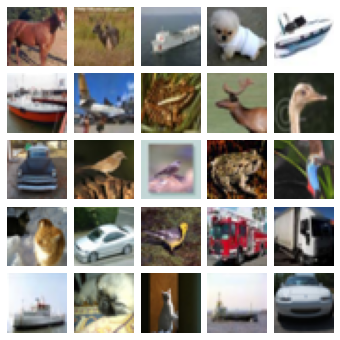

In [4]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

In [5]:
embedding_size = 256

inputs = keras.layers.Input((32, 32, 3))
x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

# building model
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                  

In [6]:
epochs = 3
learning_rate = 0.002
val_steps = 50

# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss()

# compiling and training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10,
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/3
4000/4000 [==============================] - 3995s 999ms/step - loss: 2.2163 - val_loss: 0.8820
Warmup complete
Epoch 2/3
4000/4000 [==============================] - 3992s 998ms/step - loss: 1.8902 - val_loss: 0.8504
Epoch 3/3
4000/4000 [==============================] - 3993s 998ms/step - loss: 1.6126 - val_loss: 0.8468


In [7]:
x_index, y_index = val_ds.get_slice(begin=0, size=200)
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


In [8]:
x_train, y_train = train_ds.get_slice(begin=0, size=1000)
calibration = model.calibrate(
    x_train,
    y_train,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/986 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal     0.94   0.0462037        0.889         1              0.889  0.941239



Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

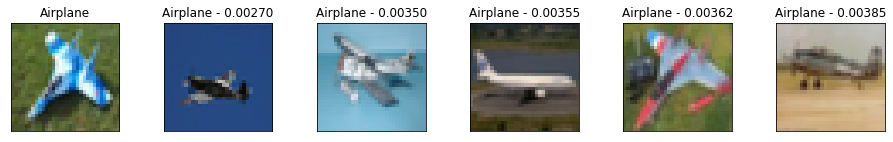

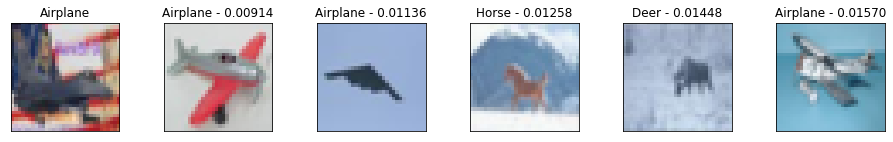

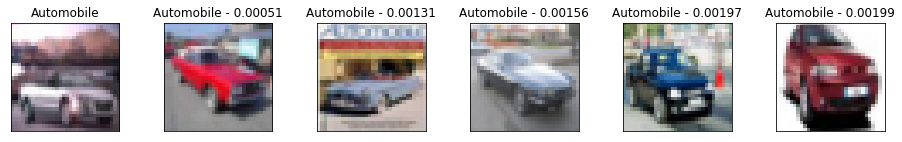

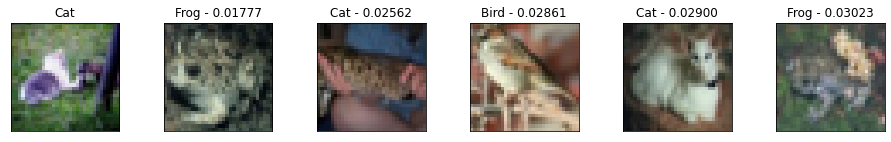

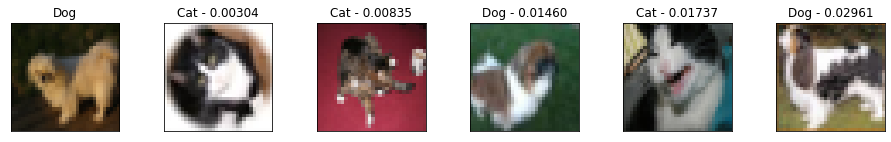

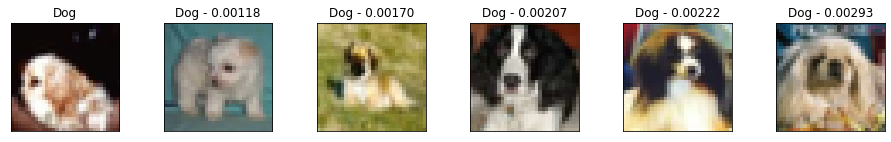

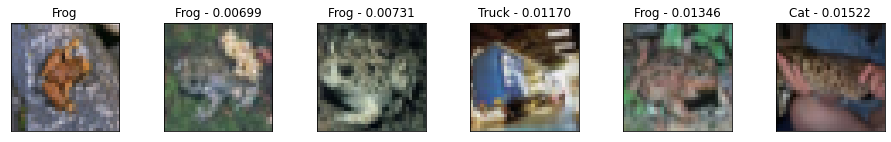

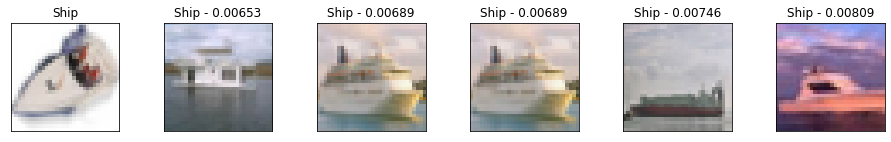

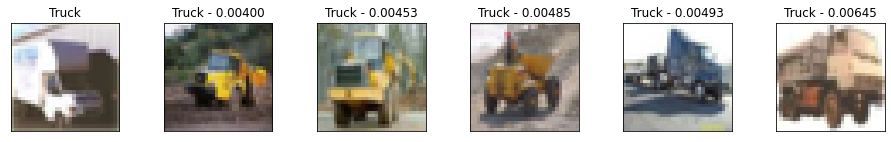

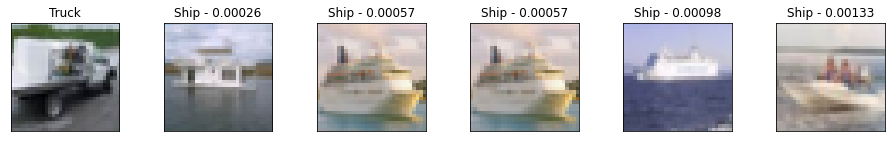

In [9]:
num_neighbors = 5
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
    "Unknown",
]
class_mapping = {c_id: c_lbl for c_id, c_lbl in zip(range(11), labels)}

x_display, y_display = val_ds.get_slice(begin=200, size=10)
# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(
        x_display[idx],
        y_display[idx],
        nns[idx],
        class_mapping=class_mapping,
        fig_size=(16, 2),
    )

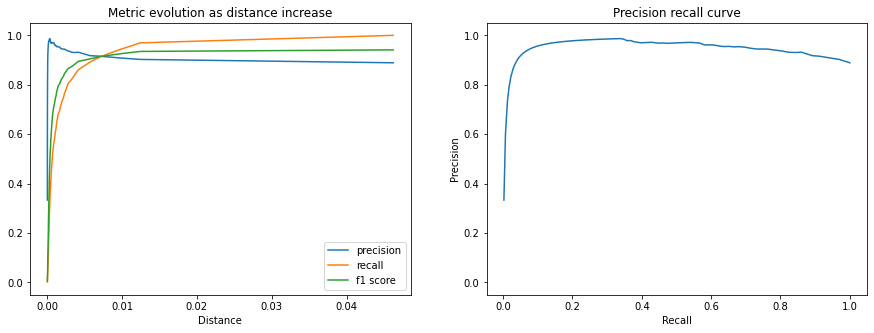

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = calibration.thresholds["distance"]

ax1.plot(x, calibration.thresholds["precision"], label="precision")
ax1.plot(x, calibration.thresholds["recall"], label="recall")
ax1.plot(x, calibration.thresholds["f1"], label="f1 score")
ax1.legend()
ax1.set_title("Metric evolution as distance increase")
ax1.set_xlabel("Distance")
ax1.set_ylim((-0.05, 1.05))

ax2.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax2.set_title("Precision recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_ylim((-0.05, 1.05))
plt.show()

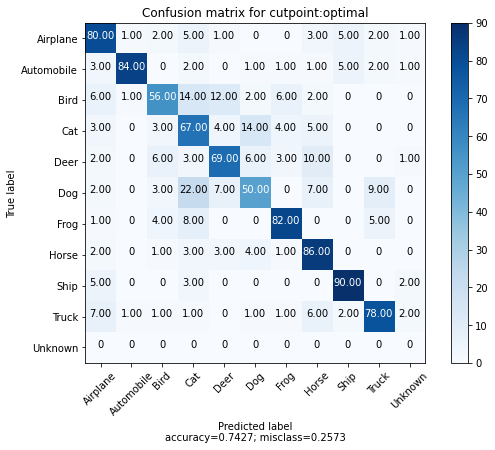

In [11]:
cutpoint = "optimal"

# This yields 100 examples for each class.
# We defined this when we created the val_ds sampler.
x_confusion, y_confusion = val_ds.get_slice(0, -1)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusion matrix for cutpoint:%s" % cutpoint,
    normalize=False,
)

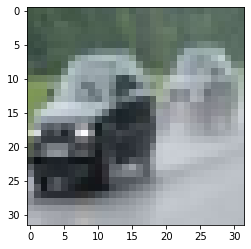

In [12]:
idx_no_match = np.where(np.array(matches) == 10)
no_match_queries = x_confusion[idx_no_match]
if len(no_match_queries):
    plt.imshow(no_match_queries[0])
else:
    print("All queries have a match below the distance threshold.")

In [14]:
# Each class in val_ds was restricted to 100 examples.
num_examples_to_clusters = 1000
thumb_size = 96
plot_size = 800
vx, vy = val_ds.get_slice(0, num_examples_to_clusters)

# Uncomment to run the interactive projector.
tfsim.visualization.projector(
    model.predict(vx),
    labels=vy,
    images=vx,
    class_mapping=class_mapping,
    image_size=thumb_size,
    plot_size=plot_size,
)

perfoming projection using UMAP


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


generating diplayabe images:   0%|          | 0/1000 [00:00<?, ?it/s]